# PREDICTIVE MODELLING part 1: winners of matches

This segment of the project focused on finding ways to predict the winner of every match. 

The match data of 55 matches played in the 2020 and 2021 seasons were used in training machine learning models. The performance of these models was then evaluated by using them to predict the match winners of the 16 matches that have already been played for 2022 season as on 23rd July. The predicted results were then validated with the actual outcomes to understand how close the predictions have been. 

In [3]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Show/Hide Code."></form>''')

In [201]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

 <h2 align="center">Predicting winners based on batting and bowling scores</h2>

The Team Batting Scores and Team Bowling Scores of the playing teams have been used as feature variables along with the teams themselves. The winning teams of the matches were the target variables. The team names being categorical variables, were required to be converted to numerical form prior to put into modelling. This conversion was done by one-hot encoding method where each of the team names were represented by a separate column and binary value of 1 or 0 were assigned under them. 1 signified that the team was playing while 0 meant otherwise.

#### Prepare the data for modelling

In [202]:
matches_info_final=pd.read_csv("C:\\Users\\DELL\\Cricdata\\matches_info_final.csv")

In [203]:
matches_info_final.head()

,match_id,Team1,Team1_batting_score,Team1_bowling_score,Team2,Team2_batting_score,Team2_bowling_score,Winner
0,1229326,Sunrisers,0.351885,0.226362,Southern Vipers,0.432089,0.575077,Southern Vipers
1,1229327,Central Sparks,0.507622,0.384719,Northern Diamonds,0.438789,0.652276,Northern Diamonds
2,1229328,Thunder,0.375013,0.427033,Lightning,0.488599,0.433753,Thunder
3,1229329,South East Stars,0.358424,0.327197,Western Storm,0.434135,0.276123,Western Storm
4,1229330,Southern Vipers,0.432089,0.575077,Western Storm,0.424910,0.270902,Southern Vipers


In [204]:
matches_info_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55 entries, 0 to 54
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   match_id             55 non-null     int64  
 1   Team1                55 non-null     object 
 2   Team1_batting_score  55 non-null     float64
 3   Team1_bowling_score  55 non-null     float64
 4   Team2                55 non-null     object 
 5   Team2_batting_score  55 non-null     float64
 6   Team2_bowling_score  55 non-null     float64
 7   Winner               55 non-null     object 
dtypes: float64(4), int64(1), object(3)
memory usage: 3.6+ KB


In [205]:
#form dummy variables for Team1 and Team2
matches_info_final_v1 = pd.get_dummies(matches_info_final, prefix=['Team1_', 'Team2_'], columns=['Team1', 'Team2'])

In [206]:
# Separate X and y sets
X = matches_info_final_v1.drop(['match_id','Winner'],axis=1)
y = matches_info_final["Winner"]

In [207]:
X.columns

Index(['Team1_batting_score', 'Team1_bowling_score', 'Team2_batting_score',
       'Team2_bowling_score', 'Team1__Central Sparks', 'Team1__Lightning',
       'Team1__Northern Diamonds', 'Team1__South East Stars',
       'Team1__Southern Vipers', 'Team1__Sunrisers', 'Team1__Thunder',
       'Team1__Western Storm', 'Team2__Central Sparks', 'Team2__Lightning',
       'Team2__Northern Diamonds', 'Team2__South East Stars',
       'Team2__Southern Vipers', 'Team2__Sunrisers', 'Team2__Thunder',
       'Team2__Western Storm'],
      dtype='object')

### LinearSVC model

Prediction of match winners is a case of a classification problem. As the sample dataset was small with just 55 rows, a simple estimator like Linear SVC (Support Vector Classifier) was used. Linear SVC is a type of Support Vector Machine (SVM) estimator. 

In [208]:
#function takes the features dataset(X), target dataset(y) and proportion of test dataset (testsize) as parameters
def LSVC_model_function(X,y,testsize):
    #import relevant libraries and packages
    from sklearn.model_selection import train_test_split
    from sklearn.svm import LinearSVC
    from sklearn.model_selection import cross_val_score
    from sklearn.metrics import confusion_matrix
    
    #perform train test split based on specified 'testsize'
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testsize, random_state=42)
    
    #train the model
    model=LinearSVC(C=1.0)
    model.fit(X_train,y_train)
    
    #make predictions for test data
    y_pred=model.predict(X_test)
    
    #print accuracies and show the confusion matrix    
    print("-------Linear SVC--------")
    print("Test Size: ",'%.1f'%(testsize*100))
    print("Train Accuracy: ",'%.2f'%(model.score(X_train, y_train)*100))
    print("Test Accuracy: ", '%.2f'%(model.score(X_test, y_test)*100)+"%")
    print(f"Cross-Validated Accuracy:{np.mean(cross_val_score(model, X, y, cv=4))*100:.2f}%")   
    print("Confusion Matrix: ")
    plt.title("LSVC model (test size:" + str(testsize*100) +"%)",fontsize=10)
    cm = pd.crosstab(y_test,y_pred,rownames=["Actual"],colnames=["Predicted"])
    sns.heatmap(cm, annot=True, cmap=sns.color_palette("Greys"))
    
    return model

In [209]:
#bootstrap sampled version
#function takes the features dataset(X), target dataset(y) and number of times to be sampled (n_rep) as parameters
def LSVC_model_function_bootstrapped(X,y,n_rep):
    from sklearn.svm import LinearSVC

    #combine X and y to replicate the original dataframe
    df = pd.concat([X, y], axis=1) 
    
    for i in range(n_rep):       
        #sample the dataframe with repetitions of rows allowed and create new larger dataframe
        df_new = df.sample(n=len(df)+i, replace=True, random_state=42+i)
        
        #split the new dataframe into X_new and y_new for features and targets respectively
        X_new = df_new.drop('Winner',axis=1)
        y_new = df_new['Winner']
               
        #train the model with the new larger dataset
        model = LinearSVC(C=1.0)    
        model.fit(X_new,y_new)

    return model

-------Linear SVC--------
Test Size:  25.0
Train Accuracy:  100.00
Test Accuracy:  64.29%
Cross-Validated Accuracy:76.24%
Confusion Matrix: 


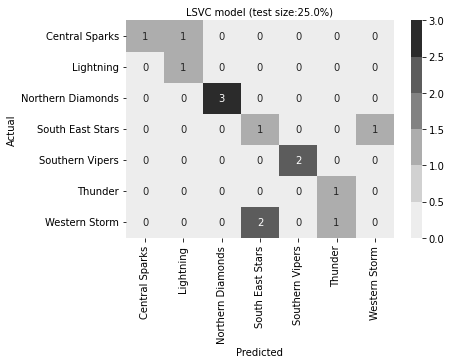

In [210]:
#Train-Test 75%-25%
WinnerbyScores_LSVC=LSVC_model_function(X,y,0.25)

-------Linear SVC--------
Test Size:  30.0
Train Accuracy:  100.00
Test Accuracy:  52.94%
Cross-Validated Accuracy:76.24%
Confusion Matrix: 


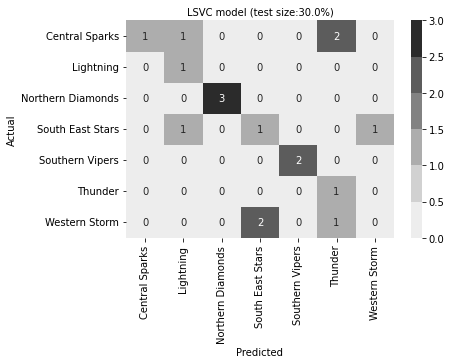

In [211]:
#Train-Test 70%-30%
WinnerbyScores_LSVC2=LSVC_model_function(X,y,0.3)

-------Linear SVC--------
Test Size:  20.0
Train Accuracy:  100.00
Test Accuracy:  81.82%
Cross-Validated Accuracy:76.24%
Confusion Matrix: 


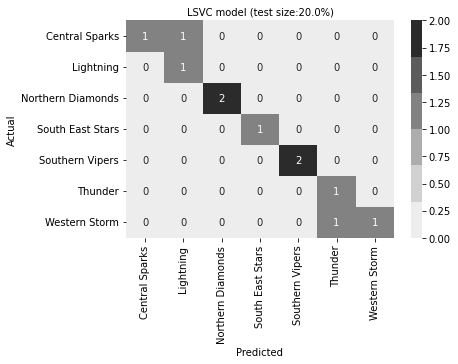

In [212]:
#Train-Test 80%-20%
WinnerbyScores_LSVC3=LSVC_model_function(X,y,0.2)

The input data was further split into train and test datasets, where the train dataset was proportionally larger than the test. The train dataset was used to fit the model which was then used to predict the target values for the test dataset. The purpose of the split was to equip the model to handle unseen data better and minimize chances of overfitting with the input dataset. Linear SVC models with different ratios of train-test split were trained and overall model accuracies of the test predictions were observed. For each model, cross-validation technique was also applied where that model was trained on different split versions of train data and evaluated on corresponding different split versions of test data. The average accuracy for different versions were observed. 

The model trained with 80%-20% train-test split turned out to be the most accurate for predicting winners for test data.

Bootstrap sampling approach- In order to compensate for the less amount of data, the 55 rows of the input dataset was randomly sampled multiple times with repetitions to increase the row numbers. The Linear SVC model was then trained with the whole dataset without any train-test split. 

In [213]:
#bootstrapped
WinnerbyScores_LSVC_boots=LSVC_model_function_bootstrapped(X,y,100)

### Check how the models works by analysing with the 2022 matches

The models were used to predict the winners of 2022 matches and then the predicted winners were compared with the actual winners.

In [216]:
matches_info_final2022=pd.read_csv("C:\\Users\\DELL\\Cricdata\\matches_info_final2022.csv")
winners_df2022=pd.read_csv("C:\\Users\\DELL\\Cricdata\\winners_df2022.csv")

In [217]:
#form dummy variables for Team1 and Team2
matches_info_final2022_v1 = pd.get_dummies(matches_info_final2022, prefix=['Team1_', 'Team2_'], columns=['Team1', 'Team2'])

X_2022 = matches_info_final2022_v1.drop(['match_id'],axis=1)

y_2022 = winners_df2022["Winner"]

In [218]:
y_pred2022_LSVC = WinnerbyScores_LSVC.predict(X_2022)
y_pred2022_LSVC2 = WinnerbyScores_LSVC2.predict(X_2022)
y_pred2022_LSVC3 = WinnerbyScores_LSVC3.predict(X_2022)

y_pred2022_LSVC_boots = WinnerbyScores_LSVC_boots.predict(X_2022)

In [219]:
predictions2022 = pd.DataFrame(data={"match_id":winners_df2022['match_id'],
                                     "Team1":matches_info_final2022['Team1'],
                                     "Team2":matches_info_final2022['Team2'],
                                     "Actual Winner":y_2022,
                                     "Predicted Winner LSVC":y_pred2022_LSVC,
                                     "Predicted Winner LSVC2":y_pred2022_LSVC2,
                                     "Predicted Winner LSVC3":y_pred2022_LSVC3,
                                     "Predicted Winner LSVC boots":y_pred2022_LSVC_boots})

In [220]:
predictions2022['Predictions LSVC'] = (predictions2022['Actual Winner']==predictions2022['Predicted Winner LSVC'])
predictions2022['Predictions LSVC2'] = (predictions2022['Actual Winner']==predictions2022['Predicted Winner LSVC2'])
predictions2022['Predictions LSVC3'] = (predictions2022['Actual Winner']==predictions2022['Predicted Winner LSVC3'])

predictions2022['Predictions LSVC boots'] = (predictions2022['Actual Winner']==predictions2022['Predicted Winner LSVC boots'])

In [221]:
predictions2022

,match_id,Team1,Team2,Actual Winner,Predicted Winner LSVC,Predicted Winner LSVC2,Predicted Winner LSVC3,Predicted Winner LSVC boots,Predictions LSVC,Predictions LSVC2,Predictions LSVC3,Predictions LSVC boots
0,202201,Central Sparks,Southern Vipers,Southern Vipers,Central Sparks,Central Sparks,Central Sparks,Central Sparks,False,False,False,False
1,202202,South East Stars,Sunrisers,South East Stars,South East Stars,South East Stars,South East Stars,South East Stars,True,True,True,True
2,202203,Western Storm,Lightning,Western Storm,Western Storm,Western Storm,Western Storm,Western Storm,True,True,True,True
3,202204,Northern Diamonds,Thunder,Northern Diamonds,Northern Diamonds,Northern Diamonds,Northern Diamonds,Northern Diamonds,True,True,True,True
4,202205,Central Sparks,Western Storm,Central Sparks,Central Sparks,Central Sparks,Central Sparks,Central Sparks,True,True,True,True
5,202206,Northern Diamonds,Sunrisers,Northern Diamonds,Northern Diamonds,Northern Diamonds,Northern Diamonds,Northern Diamonds,True,True,True,True
6,202207,Thunder,Lightning,Lightning,Thunder,Thunder,Thunder,Thunder,False,False,False,False
7,202208,Southern Vipers,South East Stars,Southern Vipers,Southern Vipers,Southern Vipers,Southern Vipers,Southern Vipers,True,True,True,True
8,202209,Central Sparks,Northern Diamonds,Northern Diamonds,Northern Diamonds,Northern Diamonds,Northern Diamonds,Northern Diamonds,True,True,True,True
9,202210,South East Stars,Thunder,South East Stars,South East Stars,South East Stars,South East Stars,South East Stars,True,True,True,True


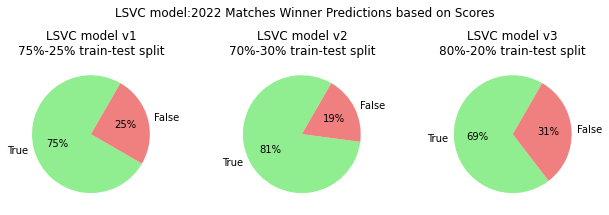

In [222]:
fig,ax = plt.subplots(nrows=1, ncols=3, figsize=(9, 3))
fig.suptitle('LSVC model:2022 Matches Winner Predictions based on Scores', fontsize=12)


plt.subplot(1,3,1).set(title='LSVC model v1\n75%-25% train-test split')
ax=predictions2022['Predictions LSVC'].value_counts().plot.pie(autopct="%.0f%%",startangle=60,
                                                                 colors=['lightgreen','lightcoral'])
ax.set_ylabel(None)

plt.subplot(1,3,2).set(title='LSVC model v2\n70%-30% train-test split')
ax=predictions2022['Predictions LSVC2'].value_counts().plot.pie(autopct="%.0f%%",startangle=60,
                                                                 colors=['lightgreen','lightcoral'])
ax.set_ylabel(None)

plt.subplot(1,3,3).set(title='LSVC model v3\n80%-20% train-test split')
ax=predictions2022['Predictions LSVC3'].value_counts().plot.pie(autopct="%.0f%%",startangle=60,
                                                                 colors=['lightgreen','lightcoral'])
ax.set_ylabel(None)

plt.tight_layout()
plt.savefig('C:/Users/DELL/Cricdata/LSVC2022predictions.jpeg',bbox_inches='tight')
plt.show()

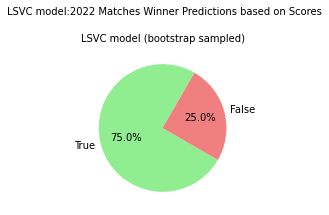

In [223]:
fig,ax = plt.subplots(nrows=1, ncols=1, figsize=(3,3))
fig.suptitle('LSVC model:2022 Matches Winner Predictions based on Scores', fontsize=10)

plt.title('LSVC model (bootstrap sampled)',fontsize=10)
ax=predictions2022['Predictions LSVC boots'].value_counts().plot.pie(autopct="%.1f%%",startangle=60,
                                                                 colors=['lightgreen','lightcoral'])
ax.set_ylabel(None)

plt.tight_layout()
plt.savefig('C:/Users/DELL/Cricdata/LSVC2022predictions_boots.jpeg',bbox_inches='tight')
plt.show()

The three versions of Linear SVC models were finally used to predict the winners of the 16 matches for the 2022 session and the predictions were then compared with the actual results. It was observed that the model version with 70%-30% train-test split got 81% of the winners right identifying 13 out of 16 winners correctly. The model with 75%-25% train-test split predicted 12 winners correctly while the third version predicted 11 correctly. 

For the bootstrap sampled model, 75% of the predictions were found to be correct and the outcome was similar to the Linear SVC model version with 75%-25% train-test split.  

<h2 align="center">Predicting winners based on toss outcome</h2>

In this approach, instead of batting and bowling scores, the toss winners and toss decisions at the beginning of the matches are used as feature variables to check how indicative they are in determining the target variables, winning teams at the end of the matches. One-hot encoding was applied to the categorical feature variables for numerical representation.  

#### Data Preparation

In [228]:
match_info = pd.read_csv('C:\\Users\\DELL\\Cricdata\\match_summary.csv')
match_info.head()

,match_id,Team1,Team2,Season,Date,Venue,Toss_Winner,Toss_Decision,Winner,Winning_Margin,ByWickets,ByRuns
0,1229326,Sunrisers,Southern Vipers,2020,29-08-2020,Chelmsford,Southern Vipers,field,Southern Vipers,7,Y,N
1,1229327,Central Sparks,Northern Diamonds,2020,29-08-2020,Birmingham,Central Sparks,bat,Northern Diamonds,9,Y,N
2,1229328,Thunder,Lightning,2020,29-08-2020,Nottingham,Thunder,bat,Thunder,4,N,Y
3,1229329,South East Stars,Western Storm,2020,29-08-2020,Beckenham,Western Storm,field,Western Storm,6,Y,N
4,1229330,Southern Vipers,Western Storm,2020,31-08-2020,Bristol,Western Storm,field,Southern Vipers,22,N,Y


In [229]:
match_info.columns

Index(['match_id', 'Team1', 'Team2', 'Season', 'Date', 'Venue', 'Toss_Winner',
       'Toss_Decision', 'Winner', 'Winning_Margin', 'ByWickets', 'ByRuns'],
      dtype='object')

In [230]:
match_toss_info = match_info[['Team1', 'Team2','Toss_Winner','Toss_Decision','Winner']]
match_toss_info.head()

,Team1,Team2,Toss_Winner,Toss_Decision,Winner
0,Sunrisers,Southern Vipers,Southern Vipers,field,Southern Vipers
1,Central Sparks,Northern Diamonds,Central Sparks,bat,Northern Diamonds
2,Thunder,Lightning,Thunder,bat,Thunder
3,South East Stars,Western Storm,Western Storm,field,Western Storm
4,Southern Vipers,Western Storm,Western Storm,field,Southern Vipers


In [231]:
match_toss_info_v1 = pd.get_dummies(match_toss_info, columns=['Team1', 'Team2','Toss_Winner','Toss_Decision'])

In [232]:
X_toss = match_toss_info_v1 .drop('Winner',axis=1)
y_toss = match_toss_info_v1["Winner"]

In [233]:
X_toss.columns

Index(['Team1_Central Sparks', 'Team1_Lightning', 'Team1_Northern Diamonds',
       'Team1_South East Stars', 'Team1_Southern Vipers', 'Team1_Sunrisers',
       'Team1_Thunder', 'Team1_Western Storm', 'Team2_Central Sparks',
       'Team2_Lightning', 'Team2_Northern Diamonds', 'Team2_South East Stars',
       'Team2_Southern Vipers', 'Team2_Sunrisers', 'Team2_Thunder',
       'Team2_Western Storm', 'Toss_Winner_Central Sparks',
       'Toss_Winner_Lightning', 'Toss_Winner_Northern Diamonds',
       'Toss_Winner_South East Stars', 'Toss_Winner_Southern Vipers',
       'Toss_Winner_Sunrisers', 'Toss_Winner_Thunder',
       'Toss_Winner_Western Storm', 'Toss_Decision_bat',
       'Toss_Decision_field'],
      dtype='object')

In [234]:
match_info2022 = pd.read_csv('C:\\Users\\DELL\\Cricdata\\match_summary2022.csv')
match_info2022.head()

,match_id,Team1,Team2,Season,Toss_Winner,Toss_Decision,Winner,Winning_Margin,ByWickets,ByRuns
0,202201,Central Sparks,Southern Vipers,2022,Southern Vipers,field,Southern Vipers,7,Y,N
1,202202,South East Stars,Sunrisers,2022,South East Stars,bat,South East Stars,80,N,Y
2,202203,Western Storm,Lightning,2022,Lightning,field,Western Storm,75,N,Y
3,202204,Northern Diamonds,Thunder,2022,Thunder,bat,Northern Diamonds,6,Y,N
4,202205,Central Sparks,Western Storm,2022,Central Sparks,bat,Central Sparks,22,N,Y


In [235]:
match_info2022.columns

Index(['match_id', 'Team1', 'Team2', 'Season', 'Toss_Winner', 'Toss_Decision',
       'Winner', 'Winning_Margin', 'ByWickets', 'ByRuns'],
      dtype='object')

In [236]:
#form dummy variables for Team1 and Team2
match_toss_info2022 = match_info2022[['Team1', 'Team2','Toss_Winner','Toss_Decision','Winner']]
match_toss_info2022_v1 = pd.get_dummies(match_toss_info2022, columns=['Team1', 'Team2','Toss_Winner','Toss_Decision'])

Xtoss_2022 = match_toss_info2022_v1.drop(['Winner'],axis=1)

ytoss_2022 = match_toss_info2022_v1["Winner"]

In [237]:
Xtoss_2022.columns

Index(['Team1_Central Sparks', 'Team1_Lightning', 'Team1_Northern Diamonds',
       'Team1_South East Stars', 'Team1_Southern Vipers', 'Team1_Sunrisers',
       'Team1_Thunder', 'Team1_Western Storm', 'Team2_Central Sparks',
       'Team2_Lightning', 'Team2_Northern Diamonds', 'Team2_South East Stars',
       'Team2_Southern Vipers', 'Team2_Sunrisers', 'Team2_Thunder',
       'Team2_Western Storm', 'Toss_Winner_Central Sparks',
       'Toss_Winner_Lightning', 'Toss_Winner_Northern Diamonds',
       'Toss_Winner_South East Stars', 'Toss_Winner_Southern Vipers',
       'Toss_Winner_Sunrisers', 'Toss_Winner_Thunder', 'Toss_Decision_bat',
       'Toss_Decision_field'],
      dtype='object')

In [238]:
set(X_toss.columns).difference(set(Xtoss_2022.columns))

{'Toss_Winner_Western Storm'}

In [239]:
Xtoss_2022['Toss_Winner_Western Storm']=0

In [240]:
Xtoss_2022.head()

,Team1_Central Sparks,Team1_Lightning,Team1_Northern Diamonds,Team1_South East Stars,Team1_Southern Vipers,Team1_Sunrisers,Team1_Thunder,Team1_Western Storm,Team2_Central Sparks,Team2_Lightning,...,Toss_Winner_Central Sparks,Toss_Winner_Lightning,Toss_Winner_Northern Diamonds,Toss_Winner_South East Stars,Toss_Winner_Southern Vipers,Toss_Winner_Sunrisers,Toss_Winner_Thunder,Toss_Decision_bat,Toss_Decision_field,Toss_Winner_Western Storm
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
1,0,0,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
2,0,0,0,0,0,0,0,1,0,1,...,0,1,0,0,0,0,0,0,1,0
3,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
4,1,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0


In [241]:
winners_df2022=pd.read_csv("C:\\Users\\DELL\\Cricdata\\winners_df2022.csv")
winners_df2022.head()

,match_id,Winner
0,202201,Southern Vipers
1,202202,South East Stars
2,202203,Western Storm
3,202204,Northern Diamonds
4,202205,Central Sparks


### Linear SVC Modelling 

Linear SVC estimator was used for modelling and different versions of the model were tried based on different train-splits. Another version of the model was also trained on bootstrapped sampled input data.

-------Linear SVC--------
Test Size:  25.0
Train Accuracy:  100.00
Test Accuracy:  64.29%
Cross-Validated Accuracy:71.15%
Confusion Matrix: 


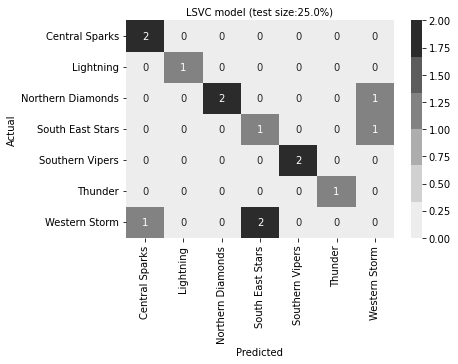

In [242]:
#Train-Test 75%-25%
WinnerbyToss_LSVC=LSVC_model_function(X_toss,y_toss,0.25)

-------Linear SVC--------
Test Size:  30.0
Train Accuracy:  100.00
Test Accuracy:  41.18%
Cross-Validated Accuracy:71.15%
Confusion Matrix: 


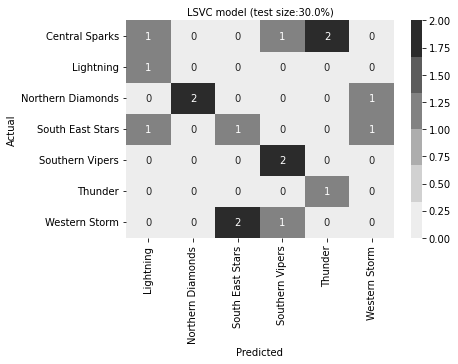

In [243]:
#Train-Test 70%-30%
WinnerbyToss_LSVC2=LSVC_model_function(X_toss,y_toss,0.3)

-------Linear SVC--------
Test Size:  20.0
Train Accuracy:  100.00
Test Accuracy:  81.82%
Cross-Validated Accuracy:71.15%
Confusion Matrix: 


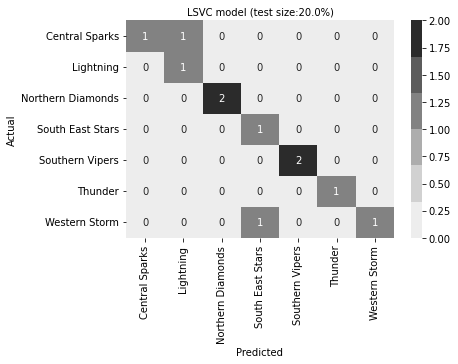

In [244]:
#Train-Test 80%-20%
WinnerbyToss_LSVC3=LSVC_model_function(X_toss,y_toss,0.2)

In [245]:
WinnerbyToss_LSVC_boots=LSVC_model_function_bootstrapped(X_toss,y_toss,100)

### Check how the models works by analysing with the 2022 matches

The models were used to predict the winners of 2022 matches and then the predicted winners were compared with the actual winners.

In [246]:
ytoss_pred2022_LSVC1 = WinnerbyToss_LSVC.predict(Xtoss_2022)
ytoss_pred2022_LSVC2 = WinnerbyToss_LSVC2.predict(Xtoss_2022)
ytoss_pred2022_LSVC3 = WinnerbyToss_LSVC3.predict(Xtoss_2022)
ytoss_pred2022_LSVC1_boots = WinnerbyToss_LSVC_boots.predict(Xtoss_2022)

In [247]:
predictions2022_toss = pd.DataFrame(data={"match_id":winners_df2022['match_id'],
                                     "Team1":match_toss_info2022['Team1'],
                                     "Team2":match_toss_info2022['Team2'],
                                     "Actual Winner":ytoss_2022,
                                     "Predicted Winner LSVC1":ytoss_pred2022_LSVC1,
                                     "Predicted Winner LSVC2":ytoss_pred2022_LSVC2,
                                     "Predicted Winner LSVC3":ytoss_pred2022_LSVC3,
                                     "Predicted Winner LSVC1 boots":ytoss_pred2022_LSVC1_boots})

predictions2022_toss['Predictions LSVC1'] = (predictions2022_toss['Actual Winner']==predictions2022_toss['Predicted Winner LSVC1'])
predictions2022_toss['Predictions LSVC2'] = (predictions2022_toss['Actual Winner']==predictions2022_toss['Predicted Winner LSVC2'])
predictions2022_toss['Predictions LSVC3'] = (predictions2022_toss['Actual Winner']==predictions2022_toss['Predicted Winner LSVC3'])

predictions2022_toss['Predictions LSVC1 boots'] = (predictions2022_toss['Actual Winner']==predictions2022_toss['Predicted Winner LSVC1 boots'])

In [248]:
predictions2022_toss[['Team1','Team2',
                 'Actual Winner',
                 'Predictions LSVC1',
                 'Predictions LSVC2',
                 'Predictions LSVC3',
                 'Predictions LSVC1 boots']]

,Team1,Team2,Actual Winner,Predictions LSVC1,Predictions LSVC2,Predictions LSVC3,Predictions LSVC1 boots
0,Central Sparks,Southern Vipers,Southern Vipers,True,True,True,False
1,South East Stars,Sunrisers,South East Stars,True,True,True,True
2,Western Storm,Lightning,Western Storm,True,True,True,True
3,Northern Diamonds,Thunder,Northern Diamonds,True,True,True,True
4,Central Sparks,Western Storm,Central Sparks,True,True,True,True
5,Northern Diamonds,Sunrisers,Northern Diamonds,True,True,True,True
6,Thunder,Lightning,Lightning,False,False,False,False
7,Southern Vipers,South East Stars,Southern Vipers,True,True,True,True
8,Central Sparks,Northern Diamonds,Northern Diamonds,True,True,True,True
9,South East Stars,Thunder,South East Stars,True,True,True,True


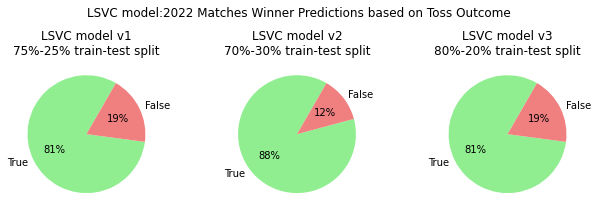

In [249]:
fig,ax = plt.subplots(nrows=1, ncols=3, figsize=(9, 3))
fig.suptitle('LSVC model:2022 Matches Winner Predictions based on Toss Outcome', fontsize=12)


plt.subplot(1,3,1).set(title='LSVC model v1\n75%-25% train-test split')
ax=predictions2022_toss['Predictions LSVC1'].value_counts().plot.pie(autopct="%.0f%%",startangle=60,
                                                                 colors=['lightgreen','lightcoral'])
ax.set_ylabel(None)

plt.subplot(1,3,2).set(title='LSVC model v2\n70%-30% train-test split')
ax=predictions2022_toss['Predictions LSVC2'].value_counts().plot.pie(autopct="%.0f%%",startangle=60,
                                                                 colors=['lightgreen','lightcoral'])
ax.set_ylabel(None)

plt.subplot(1,3,3).set(title='LSVC model v3\n80%-20% train-test split')
ax=predictions2022_toss['Predictions LSVC3'].value_counts().plot.pie(autopct="%.0f%%",startangle=60,
                                                                 colors=['lightgreen','lightcoral'])
ax.set_ylabel(None)

plt.tight_layout()
plt.savefig('C:/Users/DELL/Cricdata/LSVC2022predictions_toss.jpeg',bbox_inches='tight')
plt.show()

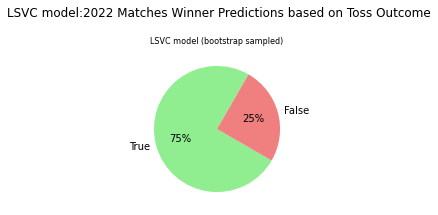

In [250]:
fig,ax = plt.subplots(1,1, figsize=(3, 3))
fig.suptitle('LSVC model:2022 Matches Winner Predictions based on Toss Outcome', fontsize=12)

   
ax.set_title('LSVC model (bootstrap sampled)',fontsize=8)
ax=predictions2022_toss['Predictions LSVC1 boots'].value_counts().plot.pie(autopct="%.0f%%",startangle=60,
                                                                 colors=['lightgreen','lightcoral'])
ax.set_ylabel(None)

plt.tight_layout()
#plt.savefig('C:/Users/DELL/Cricdata/LSVC2022predictions_boots.jpeg',bbox_inches='tight')
plt.show()

The three versions of the model and the bootstrapped version were used to predict the winners of the 2022 matches. The best predictions were done by the second model with 70-30% train-test split, getting 14 out of 16 or 88% of the winners correctly. The other two models with 75%-25% and 80%-20% train-test splits predicted 13 winners correctly. 12 predictions were made correctly by the model trained on bootstrapped input data.